In [1]:
from src.acid import *    # The actual code is in src folder
from src.utils import *
import matplotlib
import matplotlib.pyplot as plt


Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [3]:
image_directory='./images/moon.tif'    # directory of the image 
models_directory = '/models/*.h5' # directory of the models. Always ends with "*" .


'''
Read_Preprocess_Image will read the image and apply any preprocessing needed. It returns a numpy array. 

NORMALIZE: Normalize the pixel values to 0-255. Default: 1.
CONV_GS:   Convert an RGB image to grayscale. Default: 1.
INVERSE:   Invert the image: Image_New = 255 - Image. Default: 0.
EQUALIZE:  Equalizes the image histogram. Default: 0.
CLAHE:     A variant of Adaptive histogram equalization, used to improve contrast. Default: 1.
RESIZE:    Resize the image to 512x512 pixel. This is the size ACID expects. Default: 1.
LIMITS:    For large images, use only the specified pixel range. Default: no limits [0,-1,0,-1]

- In the example below, we are taking a 256x256 image and linearly interpolating it to 512x512.
  This is often helpful in detecting very small objects few pixels wide. 
- There is no universally good values for the parameters above. Trial-and-error is your best strategy.  
- ACID (and therefore MaskRCNN) expects a 3 channels RGB image as input. The models however
were trained on grayscale images with 3 duplicates of the same channel. 

'''
image = Read_Preprocess_Image(image_directory,NORMALIZE=1, CONV_GS=1,INVERSE=0,EQUALIZE=0, CLAHE=1,\
                              RESIZE=1,LIMITS=[0,256,0,256])


'''
model_inference is the main inference (predictions) function. It takes an image and the models directory as input.
Moreover, as ACID is an ensemble of 16 models, model_inference gives you the option of choosing only a subset of those.
Example: which_models = [1,2,3]. default is 'all'.
This function returns an objects master list with size [number_of_detections,11].
The 11 columns are respectively:['X_center_pix', 'Y_center_pix', 'R_pix', 'box_y1', 'box_x1', 'box_y2', 'box_x2', \
    'detection_thres','ellipticity','mask', 'object_size_pixels']
    
X_center_pix: The x coordinate of the center of the object, in pixel.
Y_center_pix: The y coordinate of the center of the object, in pixel.
R_pix: The radius of the object, in pixel.
box_** : The coordinates of the 2 diagonal points defining the bounding box.
detection_thres: The probability assigned to the detection by the model, from ~0 (not certain at all), to 1.
                  Exclusively choosing objects with a high detection_thres will lead to a conservative catalogue.

ellipticity: The ellipticity of the detected object. 1 is a perfect circle.
mask: a 512x512 binary mask. This is the shape of the detected object.
object_size_pixels: Total number of pixels of the mask.
'''
Craters_Master_list = model_inference(image,models_directory,which_models='all')


--------------------------------------------------        
                                                  
       db         ,ad8888ba,   88  88888888ba,    
      d88b       d8a.    `a8b  88  88      `a8b   
     d8.`8b     d8.            88  88        `8b  
    d8.  `8b    88             88  88         88  
   d8YaaaaY8b   88             88  88         88  
  d8aaaaaaaa8b  Y8,            88  88         8P  
 d8.        `8b  Y8a.    .a8P  88  88      .a8P   
d8.          `8b  `aY8888Ya.   88  88888888Ya.    

--------------------------------------------------                                                         
                    
Loading weights from  /mnt/d/other_data/model_01.h5
Loading weights from  /mnt/d/other_data/model_02.h5
Loading weights from  /mnt/d/other_data/model_03.h5
Loading weights from  /mnt/d/other_data/model_04.h5
Loading weights from  /mnt/d/other_data/model_05.h5
Loading weights from  /mnt/d/other_data/model_06.h5
Loading weights from  /mnt/d/other_data/

/mnt/c/Users/mad/Desktop/acid/src/acid.py:228: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(Craters_Master_list)


In [4]:
"""
As ACID is an ensemble of 16 models, a lot of the detections will be duplicates. 
ACID hence contains 2 methods of filtering duplicates and generate 1 unique catalogue. 
get_unique_iou filter duplicates by calculating the intersection_over_union score.
get_unique_Longlat filter duplicates by looking for detections with similar location and size. 
    Please see Silburt, Ali-Dib et al. (2019) for more information, and for description of the parameters. 

"""
objects_unique = get_unique_iou(Craters_Master_list,iou_thres=0.5,detection_thres=0.2)
#objects_unique = get_unique_Longlat(Craters_Master_list,thresh_rad = 1.0,thresh_longlat2 = 1.8,detection_thres=0. )


# readable_output transforms the objects_unique (or Craters_Master_list) arrays into easy to read pandas dataframes
objects_unique_readable = readable_output(objects_unique)

# Additional filtering can be imposed on the dataframe.
objects_unique_readable__ = objects_unique_readable[(objects_unique_readable['detection_thres'] > 0.2) &\
                                                    (objects_unique_readable['ellipticity'] < 1.5) & \
                                                    (objects_unique_readable['object_size_pixels'] < 0.01*(512**2))]

# Calculate the sum of all masks as 1 512x512 image. This is a binary image containing all of the detections. 
totalmask = np.sum(objects_unique_readable__['mask'])
totalmask[totalmask>0] = 1



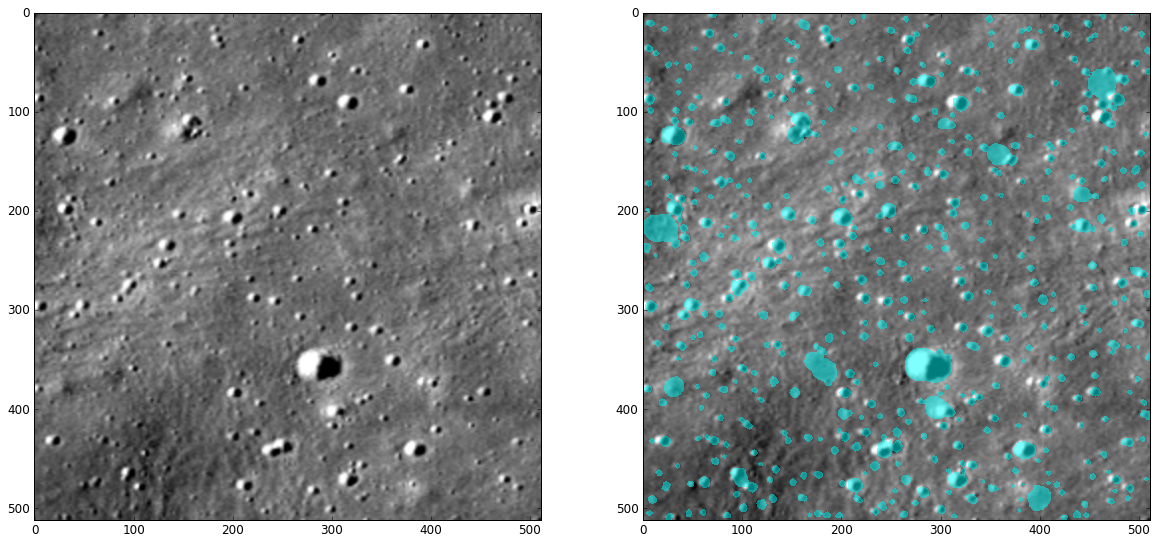

In [5]:
############ Plotting ##################
craters_image_read = plt.imread('./images/moon.tif')[0:256,0:256]
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 40.)
plt.style.use('classic')
matplotlib.style='classic'

plt.subplot(1,2,1)
plt.imshow(cv2.resize(np.array(craters_image_read), (512, 512), interpolation=cv2.INTER_LINEAR) ,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(np.array(craters_image_read), (512, 512), interpolation=cv2.INTER_LINEAR) ,cmap='gray')
totalmaskMasked = np.ma.masked_where(totalmask == 0, totalmask)

plt.imshow(totalmaskMasked,alpha=0.5,cmap='cool')
plt.show()